# Выбор локации для скважины

Допустим, вы работаете в добывающей компании. Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. ***Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.*** Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных
<br>Данные геологоразведки трёх регионов находятся в файлах:
<br>/datasets/geo_data_0.csv. 
<br>/datasets/geo_data_1.csv. 
<br>/datasets/geo_data_2.csv. 
<br>id — уникальный идентификатор скважины;
<br>f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
<br>product — объём запасов в скважине (тыс. баррелей).

Условия задачи:
<br>Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
<br>При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
<br>Бюджет на разработку скважин в регионе — 10 млрд рублей.
<br>При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
<br>После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
<br>Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
# Загрузка библиотек
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy import stats as st
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler


import warnings
warnings.simplefilter('ignore')

In [2]:
#путь к файлам
region_0=pd.read_csv('/datasets/geo_data_0.csv')
region_0.head(7)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285


In [3]:
region_1=pd.read_csv('/datasets/geo_data_1.csv')
region_1.head(7)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147


In [4]:
region_2=pd.read_csv('/datasets/geo_data_2.csv')
region_2.head(7)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478


In [5]:
# Проверка типов данных
region_0.info()
print()
region_1.info()
print()
region_2.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3

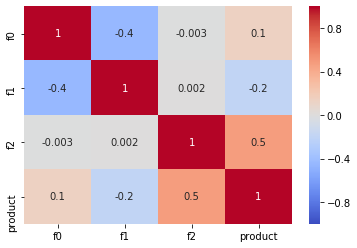

In [6]:
#Тепловая карта корреляции признаков
sns.heatmap(region_0.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

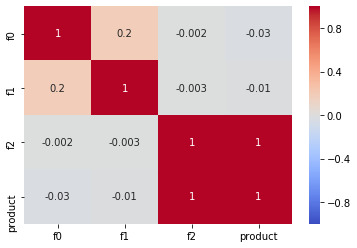

In [7]:
sns.heatmap(region_1.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

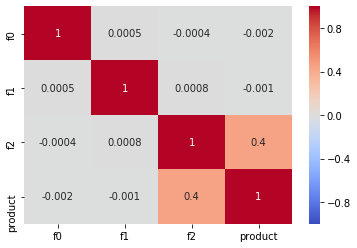

In [8]:
sns.heatmap(region_2.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

Text(0.5, 1.0, 'Распределение запасов сырья_region_0')

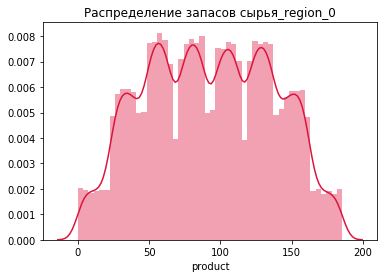

In [9]:
# График по region_0
sns.distplot(region_0['product'], color='crimson')
plt.title('Распределение запасов сырья_region_0')

Text(0.5, 1.0, 'Распределение запасов сырья_region_1')

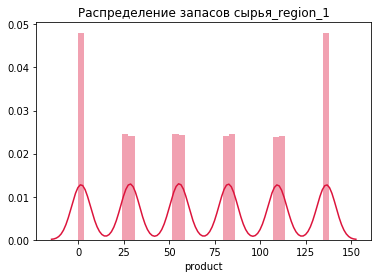

In [10]:
#region_1
sns.distplot(region_1['product'], color='crimson')
plt.title('Распределение запасов сырья_region_1')

Text(0.5, 1.0, 'Распределение запасов сырья_region_2')

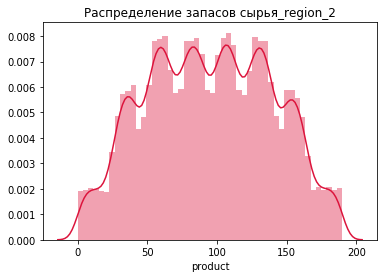

In [11]:
#region_2
sns.distplot(region_2['product'], color='crimson')
plt.title('Распределение запасов сырья_region_2')

### Вывод:
Три датасета для решения задачи подготовлены и проверены на предмет типов данных, пропущенных значений.
<br>Тепловая карта регионов отражает высокую кореляцию между 'product' (целевым признаком) и f2(признаком) от 0,4 до 1- наибольшая по 'region_1'; по 'region_0' между признаками f0 и f1 корреляция -0,4 (при более высоком ее значении возможно бы было оставить один из признаков для расчета в модели).

## Обучение и проверка модели

Обучение и проверка модели для каждого региона в части:
<br>- разбиение данных на обучающую и валидационную выборки в соотношении 75:25;
<br>- обучение модели и предсказания на валидационной выборке;
<br>- сохранение предсказания и правильных ответов на валидационной выборке;
<br>- расчет среднего запаса предсказанного сырья и RMSE модели.

In [12]:
# Отделение 25% данных для валидационной выборки, на обучающую- 75%_region_0

def split_and_train(region):
        
    features = region.drop(['id','product'] , axis = 1) #признаки
    target = region['product'] #целевой признак


    features_train, features_valid, target_train, target_valid = train_test_split(
        features,
        target,
        test_size = 0.25,
        random_state=12345
    )

    scaler = StandardScaler() # масштабирование значений
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)

    model = LinearRegression() # инициализация модели LinearRegression
    model.fit(features_train, target_train) # обучение модели на тренировочной выборке
    predictions = model.predict(features_valid) # получение предсказания модели на валидационной выборке
    predictions = pd.Series(predictions)

    R_2 = r2_score(predictions, target_valid)
    MAE = mean_absolute_error(predictions, target_valid)
    RMSE = mean_squared_error(predictions, target_valid)**0.5
    Mean_product = sum(predictions) / len(predictions)
    
    print("R_2: {0:.2f}".format(R_2))
    print("MAE: {0:.2f}".format(MAE))
    print("RMSE: {0:.2f}".format(RMSE))
    print("Mean_product: {0:.2f} тыс.баррелей".format(Mean_product))

    return RMSE, predictions, target_valid

In [13]:
print('region_0')
rmse_0, predictions_0, target_0  = split_and_train(region_0)
print()
print('region_1')
rmse_1, predictions_1, target_1  = split_and_train(region_1)
print()
print('region_2')
rmse_2, predictions_2, target_2  = split_and_train(region_2)

region_0
R_2: -1.63
MAE: 30.92
RMSE: 37.58
Mean_product: 92.59 тыс.баррелей

region_1
R_2: 1.00
MAE: 0.72
RMSE: 0.89
Mean_product: 68.73 тыс.баррелей

region_2
R_2: -3.07
MAE: 32.79
RMSE: 40.03
Mean_product: 94.97 тыс.баррелей


### Вывод: 
В данном разделе обучение и предсказание модели по регионам выдало перечень метрик и целевой показатель "Средний запас предсказанного сырья":
<br> ~R2 идеальной модели представляет 'region_1', остальные регионы показали низкое качество предсказания; 
<br> ~наилучший MAE в 0.72 и более чувствительный к выбросам RMSE в 0,89 аналогично по 'region_1';
<br> ~запас сырья по регионам от 68.73 до 94.97 тыс.баррелей- предсказанный максимум у 'region_2'.

## Подготовка к расчёту прибыли

Расчёт прибыли по выбранным скважинам и предсказаниям модели:
<br>- выбор скважины с максимальными значениями предсказаний;
<br>- суммарное целевое значение объёма сырья, соответствующее этим предсказаниям;
<br>- расчет прибыли для полученного объёма сырья.

In [14]:
# Заложенные в расчет значения показателей
budget = 1e+10
income_per_barrel = 450000
total_points = 500
best_points = 200

In [15]:
n = budget / income_per_barrel
print("Точка безубыточности: {0:.0f} тыс.баррелей".format(n))

Точка безубыточности: 22222 тыс.баррелей


In [16]:
print("Объем сырья по точке безубыточности (total_points): {0:.0f} тыс.баррелей".format(n/total_points))
print("Объем сырья по точке безубыточности (best_points): {0:.0f} тыс.баррелей".format(n/best_points))

Объем сырья по точке безубыточности (total_points): 44 тыс.баррелей
Объем сырья по точке безубыточности (best_points): 111 тыс.баррелей


In [17]:
# Функция расчета прибыли для полученного объёма сырья
def profit_count(target, predictions, best_points, budget):
    predictions = pd.Series(predictions).sort_values(ascending=False)
    selected = target[predictions.index][:best_points]
    return selected.sum() * income_per_barrel - budget

### Вывод:
Необходимый объем сырья на заданный бюджет составляет 22 222 тыс.баррелей.
<br>Предсказанный объем запаса сырья находится в диапазоне выше 44 тыс.баррелей (объем сырья на все 500 точек), но не соответствует уровню от 111 тыс.баррелей- значение для лучших 200 точек отобранных для целей ML.

## Расчёт прибыли и рисков 

Расчет рисков и прибыли для каждого региона:
- распределения прибыли техникой Bootstrap с 1000 выборок;
- средняя прибыль/ убыток, 95%-й доверительный интервал и риск убытков;
- рекомендация региона для разработки скважин с обоснованием.

In [18]:
profit = []

state = np.random.RandomState(12345)

i = 0

for t, p in [[target_0, predictions_0], [target_1, predictions_1], [target_2, predictions_2]]:
    for n in range(1000):
        target_subsample = t.reset_index(drop=True).sample(n=total_points, replace=True, random_state=state)
        predictions_subsample = pd.Series(p)[target_subsample.index]

        profit.append(profit_count(target_subsample, predictions_subsample, best_points, budget))

    profit = pd.Series(profit)
    lower =  profit.quantile(0.025)
    upper =  profit.quantile(0.975)

    mean =  profit.mean()
    
    print(f"region_{i}:")
    
    print("Средняя прибыль: {0:.2f} млн.руб.".format(int(mean)/1000000))
    print("2.5%-квантиль: {0:.2f} млн.руб.".format(int(lower)/1000000))
    print("97.5%-квантиль: {0:.2f} млн.руб.".format(int(upper)/1000000))
    
    print("Уровень риска:", (profit < 0).mean() * 100, '%')
    print()
    profit = []
    i+=1

region_0:
Средняя прибыль: 425.94 млн.руб.
2.5%-квантиль: -102.09 млн.руб.
97.5%-квантиль: 947.98 млн.руб.
Уровень риска: 6.0 %

region_1:
Средняя прибыль: 518.26 млн.руб.
2.5%-квантиль: 128.12 млн.руб.
97.5%-квантиль: 953.61 млн.руб.
Уровень риска: 0.3 %

region_2:
Средняя прибыль: 420.19 млн.руб.
2.5%-квантиль: -115.85 млн.руб.
97.5%-квантиль: 989.63 млн.руб.
Уровень риска: 6.2 %



Text(0.5, 1.0, 'Распределение прибыли')

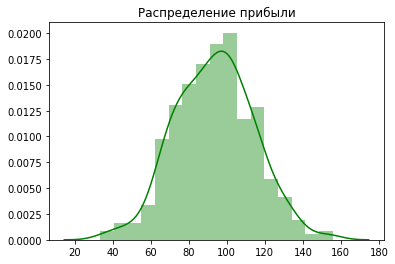

In [19]:
sns.distplot(predictions_subsample, color='green')
plt.title('Распределение прибыли')

### Вывод:
Техникой Bootstrap формируя подвыборки (псевдовыборки) получены предсказания прибыли и рисков по регионам.
<br>'region 1' по всем метрикам является самым прибыльным: выше остальных показатели средней прибыли 518.26 млн.руб. и 95%-й доверительный интервал при самом низком риске убытков всего 0.3% (вероятность соответствует условию <2.5%).